# Gaussian Density Filtering for predicting mid price raise in LOBs for 9062

In this notebook we present results of prediction if the mid price of LOB will raise in next tick. For data preparation we use GDF filters with various parameters `r` and `s`.

This notebook contains information which parameters for GDF and SVM were the best.

In [1]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from typing import Tuple
import numpy as np
import itertools
import os
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import warnings

from lob_data_utils import lob, db_result, roc_results

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

In [2]:
s_parameters = [0.1, 0.2, 0.3, 0.4, 0.5]
r_parameters = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
K = 50
length = 10000

stock = 9061

Ks = {'4': (23, 27), '10': (20, 30)}
df_res = pd.DataFrame()
for r in r_parameters:
    for s in s_parameters:
        for k, v in Ks.items():
            v1, v2 = v
            filename = '../data_res/res_{}_len{}_r{}_s{}_K{}-{}.csv'.format(stock, length, r, s, v1, v2)
            df = pd.read_csv(filename)
            df['features_num'] = k
            df_res = df_res.append(df, ignore_index=True)
df_res.drop('Unnamed: 0', axis=1, inplace=True)
df_res = df_res.apply(pd.to_numeric)
df_res.dropna(axis=0, inplace=True)
df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,features_num
1,1,50,10,0.01,0.648274,0.551536,0.1,9061,4
2,1,50,100,0.01,0.543908,0.539210,0.1,9061,4
3,1,50,1000,0.01,0.552827,0.545479,0.1,9061,4
4,1,50,10000,0.01,0.541277,0.555785,0.1,9061,4
5,10,50,1,0.01,0.648274,0.556111,0.1,9061,4


## Best parameters

### Best parameters for 4

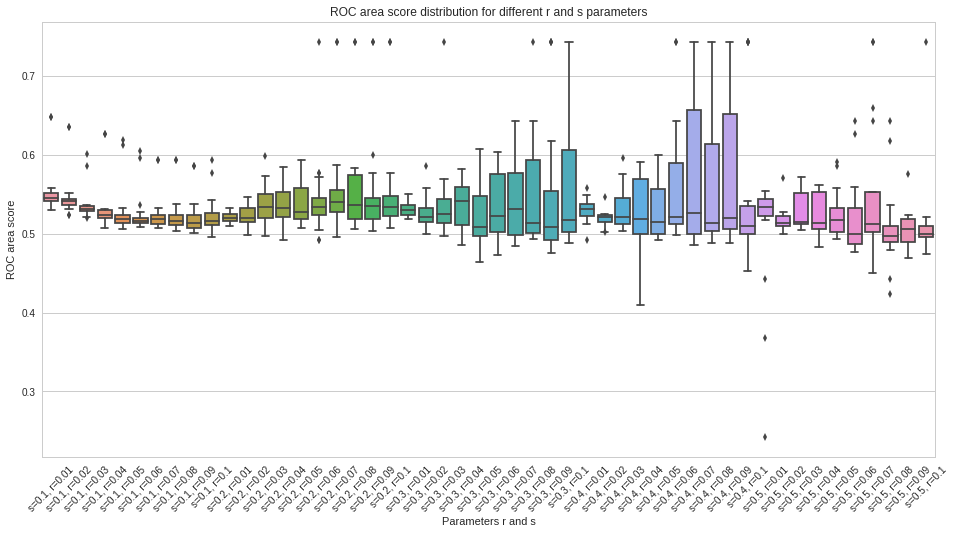

In [8]:
r_s_dict = OrderedDict()
for s in s_parameters:
    for r in r_parameters:
        r_s_dict['s={}, r={}'.format(s, r)] = df_res[df_res['s'] == s][df_res['r'] == r][
            df_res['features_num'] == 4]['roc_cv'].values

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=list(r_s_dict.values()))
plt.ylabel('ROC area score')
plt.xlabel('Parameters r and s')
_ = ax.set_xticklabels(list(r_s_dict.keys()), rotation=45)
plt.title('ROC area score distribution for different r and s parameters')

Not sure what is the best, but let's take r = 0.01 and s = 0.1 anyway (the standard deviation is small). Which SVM parameters?

In [10]:
df_res_01 = df_res[df_res['r'] == 0.01][df_res['s'] == 0.1][df_res['features_num'] == 4]
df_res_01.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,features_num,roc_log_cv,roc_log_train
1,1,50,10,0.01,0.648274,0.551536,0.1,9061,4,0.528266,0.557542
5,10,50,1,0.01,0.648274,0.556111,0.1,9061,4,0.528266,0.557542
10,100,50,1,0.01,0.557910,0.541042,0.1,9061,4,0.528266,0.557542
6,10,50,10,0.01,0.555386,0.540444,0.1,9061,4,0.528266,0.557542
12,100,50,100,0.01,0.553635,0.547311,0.1,9061,4,0.528266,0.557542


In [20]:
r_s_dict = OrderedDict()
cs = df_res['C'].unique()
gammas = df_res['gamma'].unique()
for c in cs:
    for g in gammas:
        r_s_dict['s={}, r={}'.format(c, g)] = df_res_01[df_res_01['C'] == c][df_res_01['gamma'] == g][
            df_res_01['features_num'] == 4]['roc_cv'].values

plt.figure(figsize=(16, 8))
ax = sns.heatmap(df_res_01.groupby(by=['C', 'gamma'])['roc_cv'])
plt.ylabel('ROC area score')
plt.xlabel('Parameters r and s')
_ = ax.set_xticklabels(list(r_s_dict.keys()), rotation=45)
plt.title('ROC area score distribution for different r and s parameters')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Analysis of wrong predictions

In [4]:
df_res['roc_log_cv'] = np.zeros(len(df_res)) - 1
df_res['roc_log_train'] = np.zeros(len(df_res)) - 1
roc_log_cv = []
res_log = roc_results.result_cv_10000
for idx, row in df_res.iterrows():
    roc_log_cv.append(res_log[str(int(row['stock']))])
df_res['roc_log_cv'] = roc_log_cv


roc_log_train = []
res_log = roc_results.results_10000
for idx, row in df_res.iterrows():
    roc_log_train.append(res_log[str(int(row['stock']))])
df_res['roc_log_train'] = roc_log_train

df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,features_num,roc_log_cv,roc_log_train
1,1,50,10,0.01,0.648274,0.551536,0.1,9061,4,0.528266,0.557542
2,1,50,100,0.01,0.543908,0.539210,0.1,9061,4,0.528266,0.557542
3,1,50,1000,0.01,0.552827,0.545479,0.1,9061,4,0.528266,0.557542
4,1,50,10000,0.01,0.541277,0.555785,0.1,9061,4,0.528266,0.557542
5,10,50,1,0.01,0.648274,0.556111,0.1,9061,4,0.528266,0.557542


## Tunning of `r` and `s` parameters for filters

In [5]:
df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=rr, columns=ss)
for i, row in df_res.groupby(['r', 's']).max().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()

NameError: name 'rr' is not defined

### SVM hyperparameter tunnig (`gamma` and `C`)

In [ ]:
df_g = pd.DataFrame(index=sorted(df_res['C'].unique()), columns=sorted(df_res['gamma'].unique()))
for i, row in df_res.groupby(['C', 'gamma']).max().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()

In [ ]:
from itertools import product

cs = sorted(df_res['C'].unique())
gammas = sorted(df_res['gamma'].unique())

svm_params = product(gammas, cs)
gdf_params = list(product([int(r*100) for r in rr], [int(s*100) for s in ss]))


df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=list(svm_params), columns=list(gdf_params))

for i, row in df_res.iterrows():
    r = int(row['r'] * 100)
    s = int(row['s'] * 100)
    column = (r, s)
    index = (row['C'], row['gamma'])
    df_g[column].loc[index] = row['roc_train']
df_g = df_g.apply(pd.to_numeric)   
df_g.head()

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
gdf_params_10 = [g for g in list(gdf_params) if g[0] >= 5]
sns.heatmap(df_g[gdf_params_10], annot=True)

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
gdf_params_5 = [g for g in list(gdf_params) if g[0] < 5]
sns.heatmap(df_g[gdf_params_5], annot=True)

In [ ]:
plt.plot(df_res['roc_cv'].values)
plt.plot(df_res['roc_train'].values)

## Learning curves

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def read_gdf_data(stock, r, s, K=50, length=10000):
    filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
    if not os.path.exists(os.path.join('data_gdf',  filename + '.csv')):
        print('GDF file ', filename, 'does not exist')
    try:
        dfs, dfs_cv, dfs_test = lob.load_prepared_data(
            filename, data_dir='data_gdf/', cv=True, length=length)
        if dfs is None:
            print('none')
    except Exception as e:
        print(filename, 'not read', e)
    return dfs, dfs_cv, dfs_test

def plot_svm_learning_curve(df, C=1000, gamma=1):
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
    X = df.loc[:, gdf_columns]
    y = df[['mid_price_indicator']].values
    c, r = y.shape
    y = y.reshape(c, )
    y[0] = 0
    clf.fit(X, y)
    plot_learning_curve(clf, X, y)
    return clf

In [ ]:
row = df_res.max()
r = row['r']
s = row['s']
gamma = row['gamma']
C = row['C']

df, df_cv, df_test = read_gdf_data(stock, r, s)
clf = plot_svm_learning_curve(df, C=C, gamma=gamma)

In [ ]:
row = df_res.min()
r = row['r']
s = row['s']
gamma = row['gamma']
C = row['C']

df, df_cv, df_test = read_gdf_data(stock, r, s)
clf = plot_svm_learning_curve(df, C=C, gamma=gamma)

### Validation curve

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


def plot_validation_curve(df, c_range, gamma_range, c_start=1, gamma_start=1):
    gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
    X = df.loc[:, gdf_columns]
    y = df[['mid_price_indicator']].values
    c, r = y.shape
    y = y.reshape(c, )
    y[0] = 0
    train_scores, test_scores = validation_curve(
        SVC(kernel='rbf', C=c_start), X, y, param_name="gamma", param_range=gamma_range, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(gamma_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(gamma_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(gamma_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(gamma_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    
    train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', gamma=gamma_start), X, y, param_name="C", param_range=c_range, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(c_range, train_scores_mean, label="Training score C",
                 color="red", lw=lw)
    plt.fill_between(c_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="red", lw=lw)
    plt.semilogx(c_range, test_scores_mean, label="Cross-validation score C",
                 color="green", lw=lw)
    plt.fill_between(c_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="green", lw=lw)
    
    
    plt.legend(loc="best")

In [ ]:
row = df_res.max()
r = row['r']
s = row['s']
gamma = row['gamma']
C = row['C']
print(row)
df, df_cv, df_test = read_gdf_data(stock, r, s)
plot_validation_curve(df, c_range=np.logspace(1, 5, 5), 
                      gamma_range=np.logspace(1, 5, 5), c_start=100, gamma_start=1000)

In [ ]:
row = df_res.max()
r = row['r']
s = row['s']

gamma = row['gamma']
C = row['C']
print(row)
df, df_cv, df_test = read_gdf_data(stock, r, s)
plot_validation_curve(df, c_range=np.logspace(0.1, 3, 6), 
                      gamma_range=np.logspace(1.1, 3, 6), c_start=10, gamma_start=10)

In [ ]:
plot_validation_curve(df, c_range=np.logspace(1, 5, 5), 
                      gamma_range=np.logspace(1, 5, 5), c_start=1000, gamma_start=1000)

In [ ]:
plot_svm_learning_curve(df, C=0.1, gamma=0.1)

In [ ]:
row = df_res.max()
r = 0.1
s = 0.5
gamma = 7000
C = 70

df, df_cv, df_test = read_gdf_data(stock, r, s)
clf = plot_svm_learning_curve(df, C=C, gamma=gamma)

